<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/group_svm/Adolescent_Group_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adolescent Group Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- This notebook goes from the pre-processed raw data in MATLAB:
  - loading from storage in AWS
  - masks the data
  - normalizes data by run
  - splits the subjects into train validation and test sets where there is no crossing of subjects to control for data leakage.
  - trains the data and saves model, data values and metrics to AWS
- SVM training per group (subject ids of '100XX-XXXXX' for Adolescent (child) and '300XX-XXXXX' for Young Adult)

### Mount Google Drive and clone repository
- open to source directory

In [1]:
from google.colab import drive, files
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/group_svm
!ls


Cloning into 'teambrainiac'...
remote: Enumerating objects: 1403, done.
remote: Counting objects: 100% (1403/1403), done.
remote: Compressing objects: 100% (1101/1101), done.
remote: Total 1403 (delta 907), reused 558 (delta 285), pack-reused 0
Receiving objects: 100% (1403/1403), 84.70 MiB | 11.26 MiB/s, done.
Resolving deltas: 100% (907/907), done.
/content/teambrainiac/source/group_svm
access_data.py		    Group_charts.ipynb
Adolescent_Group_SVM.ipynb  __init__.py
analysis.py		    process.py
cross_validation.py	    Timeseries_Cross_Validation.ipynb
data			    train.py
dataframes.py		    visualize.py
Explore_data.ipynb	    Young_Adult_Group_SVM.ipynb
Group_All_MASK_SVM.ipynb


### Load path_config.py 
- we are already in the source directory so we can just load this file without changing directories

In [3]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


### Import libraries


In [4]:
# Import libraries
!pip install boto3 nilearn
import pickle
from visualize import plot_alphas
from train import run_grp_svm_model
from analysis import create_bmaps, get_threshold_image, metrics
from process import *
from access_data import *

from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

     |████████████████████████████████| 132 kB 4.1 MB/s 
     |████████████████████████████████| 9.6 MB 17.2 MB/s 
     |████████████████████████████████| 8.7 MB 39.1 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 138 kB 56.4 MB/s 
     |████████████████████████████████| 38.1 MB 329 kB/s 
     |████████████████████████████████| 127 kB 53.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 r

### Load Unmasked Data from AWS 
- normalize and transform data
- and obtain Adolescent subjects from first 33 subject IDs

In [ ]:
%%time
# Get mat file 
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
label_type = 'rt_labels'
from_mat = 'unnorm' #unnorm
data_type = "AD_AD"
m_path_ind = 0 #get sub_mask data in mask_data key
l_path_ind = 0 #get data in data from rt_label key

#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
filename = f"all_data_{mask_type}_{from_mat}_2d.pkl"
subject_ids = data_path_dict['subject_ID']

# Split dataset into Adolescent
ad = subject_ids[:33]
print("Number of subjects for Adolescent ", len(ad))

# process data if not in AWS already
obj_name, _, _ = access_aws()
statement = False
for i in obj_name:
  if filename in i.key:
    statement = True 
     
if statement == False:
  print(f"Masking mat data to {mask_type}...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, m_path_ind, l_path_ind)
  print(f"Saving data to local path {data_path}{filename}")
  f = open(f"{data_path}{filename}", "wb")
  pickle.dump(data, f)
  f.close()
else:
  print("Loading in masked data")
  data = access_load_data(filename, False)

Number of subjects for Adolescent  33
Masking mat data to nacc_aal...


0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 496.71it/s]
1it [00:11, 11.75s/it]
100%|██████████| 4/4 [00:00<00:00, 493.93it/s]
2it [00:25, 12.77s/it]
100%|██████████| 4/4 [00:00<00:00, 539.37it/s]
3it [00:40, 14.10s/it]
100%|██████████| 4/4 [00:00<00:00, 498.48it/s]
4it [00:52, 13.13s/it]
100%|██████████| 4/4 [00:00<00:00, 571.45it/s]
5it [01:04, 12.56s/it]
100%|██████████| 4/4 [00:00<00:00, 565.94it/s]
6it [01:16, 12.36s/it]
100%|██████████| 4/4 [00:00<00:00, 516.09it/s]
7it [01:27, 12.02s/it]
100%|██████████| 4/4 [00:00<00:00, 611.64it/s]
8it [01:38, 11.66s/it]
100%|██████████| 4/4 [00:00<00:00, 542.69it/s]
9it [01:49, 11.40s/it]
100%|██████████| 4/4 [00:00<00:00, 545.48it/s]
10it [02:00, 11.39s/it]
100%|██████████| 4/4 [00:00<00:00, 490.71it/s]
11it [02:11, 11.41s/it]
100%|██████████| 4/4 [00:00<00:00, 401.24it/s]
12it [02:23, 11.60s/it]
100%|██████████| 4/4 [00:00<00:00, 551.43it/s]
13it [02:35, 11.51s/it]
100%|██████████| 4/4 [00:00<00:00, 606.51it/s]
14it [02:46, 11.40s/

Saving data to local path data/all_data_nacc_aal_unnorm_2d.pkl
CPU times: user 6min 17s, sys: 1min 15s, total: 7min 33s
Wall time: 10min 27s


## SVM Adolescent
- Split subject IDs three ways to make Train, Val, Test sets
- Perform Z-Normalization on the data per run per subject by calling transform_data()
- Run SVM on PSC and Z-normalized Data
- Train/Val/Test set run 2 and 3

In [9]:
# get train, test val data
train_ids = ad[:26]
#val_ids = ad[23:28]
test_ids = ad[36:33]

group_sub_ids = (train_ids, False, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = False
runs_test = [1,2] #2 # grabds the third run
znorm = "Detrend_Znorm" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization


print("Number of Adolescent training examples: ", len(train_ids, train_ids)
#print("Number of Adolescent validation examples: ", len(val_ids))
print("Number of Adolescent testing examples: ", len(test_ids), test_ids)
print(len(ad))

model_dict = run_grp_svm_model(data, mask_type, group_sub_ids, runs_train, runs_val, runs_test, znorm, data_type)

Number of Adolescent training examples:  26
Number of Adolescent testing examples:  7
33
Data will be detrended and znorm scaled by columns per run...
Crossvalidation already completed, do not need validation set.
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizing the data...
Detrending and znormalizin

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Predicting on Test set...
Test Accuracy: 0.5238095238095238
upload complete for metrics/group_svm/mask/AD_detrend_[2, 3]_mask_metrics.pkl
upload complete for models/group/AD_detrend_[2, 3]_mask_X_model.pkl
Classification report for mask test_classreport
              precision    recall  f1-score   support

           0       0.67      0.09      0.16       588
           1       0.51      0.95      0.67       588

    accuracy                           0.52      1176
   macro avg       0.59      0.52      0.42      1176
weighted avg       0.59      0.52      0.42      1176

upload complete for metrics/group_svm/mask/AD_detrend_model_[2, 3]_mask_test_classreport.csv


## Visualization Analysis
- Load SVM pretrained model
- Load X train data and labels
- Check Support Vectors
- Create Alphas from dual coefficients/model weights and load into support vector indices
- Take the dot product of alphas and X train data and create a bmap
- Using the bmap we recreate the 4D space using 3d mask indices and load the dot product of alphas and X train information into this matrix
- Use this information to visualize the areas of the brain that were learned by the SVM to be areas close to the decision boundary, areas thought of as either upregulating or downregulating

In [ ]:
# Load model
#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)

mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
data_type = "AD_AD"
runs_train = [1,2]
runs_id = [i + 1 for i in runs_train]
m_path_ind = 0 #get sub_mask data in mask_data key


model_dict = access_load_data(f'models/group/{data_type}_{runs_id}_{mask_type}_X_y_model.pkl', False)
print(model_dict.keys())
clf = model_dict['model'][0]
X = model_dict['X_train'][0]
y = model_dict['y_train'][0]

dict_keys(['model', 'X_train', 'y_train'])


In [ ]:
print("number of support vectors:", len(clf.support_))
print("indices of support vectors:", clf.support_)
print("support vector shape: ", clf.support_vectors_.shape)
print("number of support vectors for each class:", clf.n_support_)
print("# Values scaled to fit between -1 and 1:", clf.dual_coef_.shape)
print("length of X-train:", len(X))

number of support vectors: 1982
indices of support vectors: [  14   15   19 ... 3852 3855 3856]
support vector shape:  (1982, 237979)
number of support vectors for each class: [999 983]
# Values scaled to fit between -1 and 1: (1, 1982)
length of X-train: 3864


#### Create Beta map for Visualization
- Create Alphas and Bmaps

In [ ]:
# Load in affine matrix - helps map the data coordinates to real world coordinates
affine_image = access_load_data('w3rtprun_01.nii',False)
t1_image = access_load_data('MNI152.nii',False)

# Load in the mask indices to create bmaps
indices_mask = load_mask_indices(data_path_dict, mask_type, m_path_ind)
bmap3, bmap2_3, alphas1 = create_bmaps(clf, X, indices_mask, affine_image)

mask shape: (79, 95, 79)


In [ ]:
# View Slices of the brain
# get bmaps for visualization
outfile = None

if outfile == None:
  output_file = None
else:
  output_file = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_plt_z_1.png"

title = f"Young Adult {mask_type}"
im = plotting.plot_img(bmap3, 
                        bg_img = t1_image,
                        colorbar=True, 
                        cut_cords = (-35,-20,0,20,35,50,65,70),
                        cmap='cold_white_hot', 
                        display_mode='z',
                        output_file = output_file
                        )
im.title(title, 
        x=0.01, 
        y=0.99, 
        size=15, 
        color='w', 
        bgcolor='black'
        )



# Plot Stat maps using thresholds for signal intensity values
score_percentile = '98%' # threshold by top 2% and bottom 2%
image_intensity = 3.0
threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3, score_percentile, image_intensity)

outfile = None
if outfile == None:
  output_file = None
else:
  output_file1 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_percent_statmap_y_1.png"
  output_file2 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_intensity_statmap_y_1.png"


title2=f'Percentile Signal threshold Young Adult {mask_type} at {score_percentile}'
title3=f'Image intensity threshold at {image_intensity} Young Adult {mask_type}'
# Plotting image thresholded by percentile
im2 = plotting.plot_img(threshold_percentile_img, 
                        bg_img = t1_image, 
                        display_mode='y', 
                        cut_coords=cut_cords = (-35,-20,0,20,35,50,65,70),
                        colorbar=True,
                        cmap = "cold_white_hot",
                        output_file=output_file1
                       )
im2.title(title2, 
          x=0.01, 
          y=0.99, 
          size=15, 
          color='w', 
          bgcolor='black'
          )

# Showing intensity threshold image
im3 = plotting.plot_img(threshold_value_img, 
                        bg_img = t1_image, 
                        display_mode='y', 
                        cut_coords=cut_cords = (-35,-20,0,20,35,50,65,70), 
                        colorbar=True,
                        cmap = "cold_white_hot",
                        output_file=output_file2
                       )
im3.title(title3, 
          x=0.01, 
          y=0.99, 
          size=15, 
          color='w', 
          bgcolor='black'
          )





def plot_alphas(alphas,alpha_labels, time, title, mask_type):
  """

  :param alphas:
  :param alpha_labels:
  :param time:
  :param title:
  :return:
  """
  fig, ax = plt.subplots(1,1,figsize=(15, 5))
  ax.plot(alphas, label='scaled voxel tc')
  ax.plot(alpha_labels,  label='predictor tc')
  ax.set_xlabel('time [volumes]', fontsize=20)
  ax.tick_params(labelsize=12)
  ax.set_title(f"Alpha signal for {title} {time} time points")
  ax.legend(loc = 'upper right')
  plt.show()
  plt.savefig(f'/content/gdrive/MyDrive/{data_type}_{mask_type}_alpsig_1.png')


# Plot the time series with alpha signals and labels
title = f"Young Adult Group {mask_type} Last"

timepoints = [(200, -2, 2)]#[(100, -3, 3), 
for time, min, max in timepoints:
  alpha_labels = np.where(y == 0,min,max)
  plot_alphas(alphas1[-time:],alpha_labels[-time:], time, title, mask_type)



# Plot interactive maps     
html_view = plotting.view_img(bmap3, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              cut_coords=[-10, 13, -8],
                              title=f"Young Adult {mask_type}")
html_view.save_as_html(f'/content/gdrive/MyDrive/{data_type}_{mask_type}_1.html')



"""
# Plotting all slices in brain
title = f'Threshold image with intensity value for Young Adult {mask_type}'
output_file3 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_zfullsliceCOLDhot.png"
plotting.plot_img(bmap3, 
                  #threshold_percentile_img, 
                  bg_img = t1_image, 
                  #display_mode='z', 
                  cut_coords=(1, 55, -22), 
                  annotate = True,
                  #title=title, 
                  colorbar=True,
                  cmap = "cold_hot",
                  output_file=output_file3
                  )"""

In [ ]:
# View Slices of the brain
# get bmaps for visualization
title = f"Adolescent Group {mask_type}"
output_file = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_statmap_z_1.png" 

bmap3, bmap2_3, alphas1 = create_bmaps(clf, X, indices_mask, affine_image)
plotting.plot_stat_map(bmap3, 
                       bg_img = t1_image,
                       colorbar=True, 
                       cmap='hot', 
                       display_mode='z',
                       title=f"{title}",
                       output_file = output_file)


Shape of beta map:  (1, 237979)


In [ ]:
# Plot Stat maps using thresholds for signal intensity values
score_percentile = '98%' # threshold by top 2% and bottom 2%
image_intensity = 3.0
threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3, score_percentile, image_intensity)
output_file1 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_percent_statmap_y_1.png"
output_file2 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_intensity_statmap_y_1.png"


# Plotting image thresholded by percentile
plotting.plot_stat_map(threshold_percentile_img, 
                       bg_img = t1_image, 
                       display_mode='y', 
                       cut_coords=5,
                       #title=f'98th percentile Signal threshold Adolescent {mask_type}', 
                       colorbar=True,
                       cmap = "cold_hot",
                       black_bg = True,
                       output_file=output_file1)

# Showing intensity threshold image
plotting.plot_stat_map(threshold_value_img, 
                       bg_img = t1_image, 
                       display_mode='y', 
                       cut_coords=5,
                       #title=f'Image intensity threshold Adolescent {mask_type}', 
                       colorbar=True,
                       cmap = "cold_hot",
                       black_bg = True,
                       output_file=output_file2)

In [ ]:
def plot_alphas(alphas,alpha_labels, time, title, mask_type):
  """

  :param alphas:
  :param alpha_labels:
  :param time:
  :param title:
  :return:
  """
  fig, ax = plt.subplots(1,1,figsize=(15, 5))
  ax.plot(alphas, label='scaled voxel tc')
  ax.plot(alpha_labels,  label='predictor tc')
  ax.set_xlabel('time [volumes]', fontsize=20)
  ax.tick_params(labelsize=12)
  ax.set_title(f"Alpha signal for {title} {time} time points")
  ax.legend(loc = 'upper right')
  plt.show()
  plt.savefig(f'/content/gdrive/MyDrive/{data_type}_{mask_type}_alpsig_1.png')

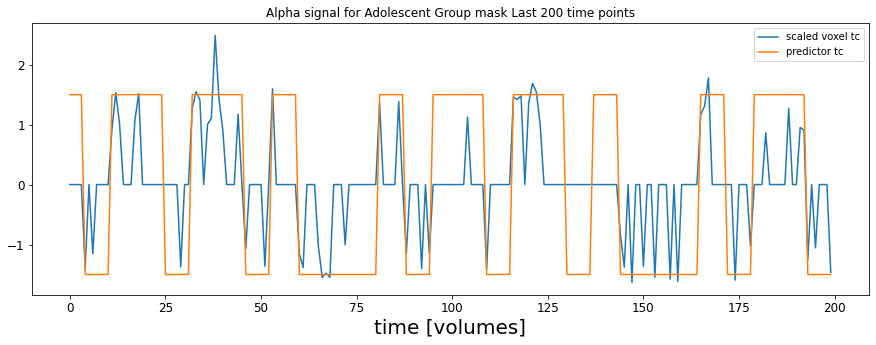

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the time series with alpha signals and labels
#plt.savefig(f"/content/gdrive/MyDrive/{data_type}_{mask_type}_alphasig_1.png")

title = f"Adolescent Group {mask_type} Last"
timepoints = [(200, -1.5, 1.5)]#(100, -1.5, 1.5), 
for time, min, max in timepoints:
  alpha_labels = np.where(y == 0,min,max)
  plot_alphas(alphas1[-time:],alpha_labels[-time:], time, title, mask_type)

In [ ]:
# Plot interactive maps   
html_view = plotting.view_img(bmap3, 
                              bg = t1_image, 
                              threshold='98%', 
                              cmap = 'hot', 
                              cut_coords=[-10, 13, -8],
                              title="Motor contrast")
html_view.save_as_html(f'/content/gdrive/MyDrive/{data_type}_{mask_type}.html')

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()


In [ ]:
# Plotting all slices in brain
title = f'Threshold image with intensity value for for Adolescent {mask_type}'
output_file3 = f"/content/gdrive/MyDrive/{data_type}_{mask_type}_zfullslice.png"
plotting.plot_stat_map(threshold_percentile_img, 
                       bg_img = t1_image, 
                       display_mode='z', 
                       cut_coords=79, 
                       annotate = True,
                       title=title, 
                       colorbar=True,
                       output_file=output_file3)


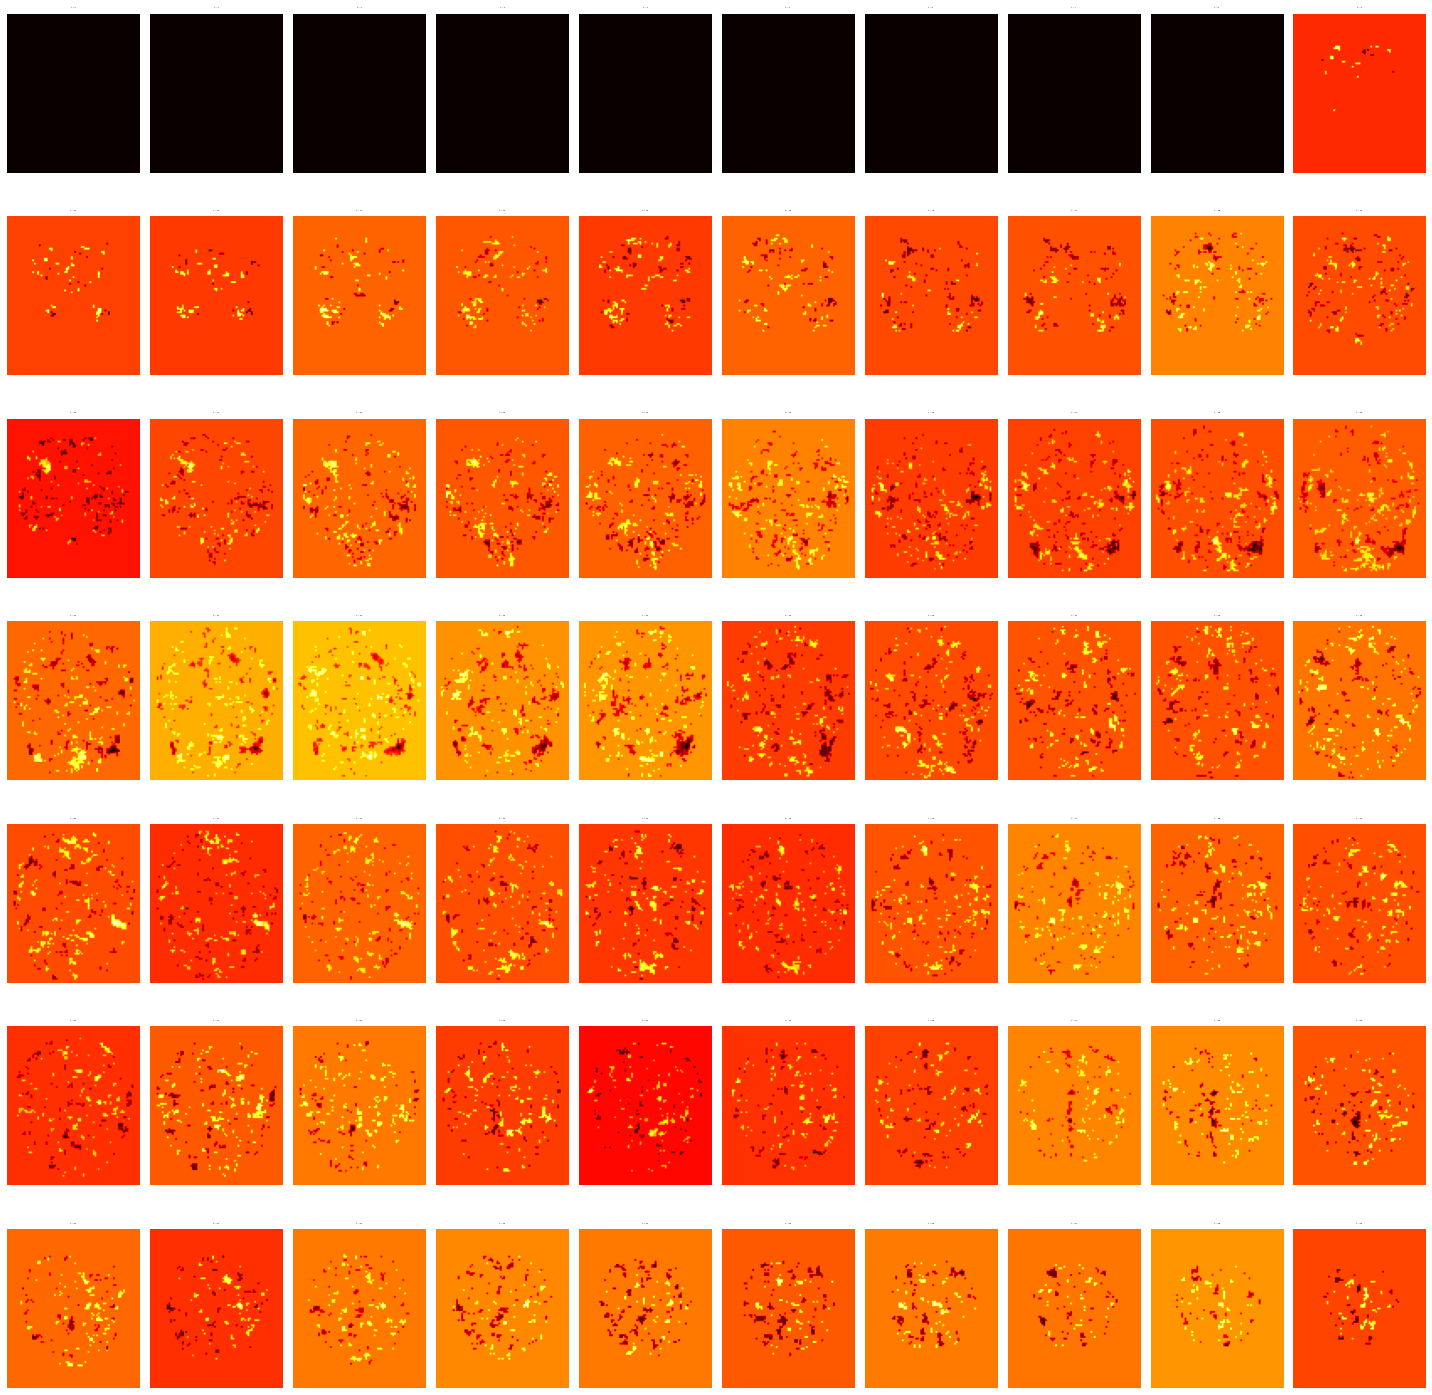

In [ ]:


fig, axes = plt.subplots(ncols=10, nrows=7, figsize=(20, 20))  # 70 slices
# Loop over the first 70 slices
for t, ax in enumerate(axes.flatten()):   
    ax.imshow(bmap2_3[:, :, t].T, cmap='hot')#, origin='lower')  # index with t!
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=2)
fig.tight_layout()

## Predict Adolescent on Young Adult Model

In [ ]:
# get train, test val data
train_ids = ad[:23]
val_ids = ad[23:28]
test_ids = ad[28:34]

group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = [1,2]
runs_test = [1,2] #2 # grabds the third run
norm = "RUNS" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization
mask_type = 'whole_brain'
model_type = "YA_YA_pscz"
data_type = "Adolescent_YA"
runs_id = [i+1 for i in runs_train]

print("Number of Adolescent training examples: ", len(train_ids))
print("Number of Adolescent validation examples: ", len(val_ids))
print("Number of Adolescent testing examples: ", len(test_ids))
print(len(ad))

# Get the Data normalized and concatenated
X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_val, runs_test, norm)

# Load YA model and predict the Adol data
model_dict = access_load_data(f"models/group/{model_type}_{runs_id}_{mask_type}_X_y_model.pkl", False)
print(model_dict.keys())
clf = model_dict['model'][0]

# Analyze results
metrics(clf, X_v, y_v, X_t, y_t, data_type, runs_id, mask_type)

Number of Adolescent training examples:  23
Number of Adolescent validation examples:  5
Number of Adolescent testing examples:  5
33
Normalizing Each based on RUNS...
Final X Train data shape (3864, 237979)
Final y Train data shape  (3864,)
Final X Val data shape (840, 237979)
Final y Val data shape  (840,)
Final X Test data shape (840, 237979)
Final y Test data shape  (840,)
dict_keys(['model', 'X_train', 'y_train'])
Predicting on Validation set...
Validation Accuracy: 0.7214285714285714
Predicting on Test set...
Test Accuracy: 0.7345238095238096
upload complete for metrics/group_svm/Adolescent_YA_model_[2, 3]_whole_brain_validation_classreport.csv
Classification report for whole_brain validation_classreport
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       420
           1       0.71      0.75      0.73       420

    accuracy                           0.72       840
   macro avg       0.72      0.72      0.72       840
weighted

True